In [3]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import math
import statsmodels.api as sm
import os, glob
import datetime
import seaborn as sns
import pickle
from tqdm import tqdm

In [4]:
def fit_inferred_exponential(y):
    _x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    _y = [y_val if (y_val and y_val>0) else np.nan for y_val in y]
    log_y = np.log(_y)
    _xsm = sm.add_constant(_x)
    results = sm.OLS(log_y,_xsm, missing="drop").fit()
    b,a = results.params
    r = results.rsquared
    return a,b,r # exp growth rate, "initial" value

In [6]:
# download api data and cache (to disk)
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingRate&metric=newCasesBySpecimenDateRollingSum&format=json"#&release=2021-06-13"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
df.to_pickle(top_date + "_dataframe_msoa.pickle")
print(top_date)

2021-06-13


In [4]:
xls = pd.ExcelFile('COVID-19-weekly-announced-vaccinations-10-June-2021.xlsx')
vax_df = pd.read_excel(xls, 'MSOA')

xls = pd.ExcelFile('SAPE22DT4-mid-2019-msoa-syoa-estimates-unformatted.xlsx')
pop_df = pd.read_excel(xls, 'Mid-2019 Persons')

In [5]:
start_row = 5
msoa_col = 0
pop_col_1 = 7 #+60
pop_col_2 = 150
i = start_row
pop = {}
while (True):
    try:
        msoa = pop_df.iloc[i, msoa_col]
        pop[msoa] = np.sum(pop_df.iloc[i, pop_col_1:pop_col_2])
        i += 1
    except:
        break

In [6]:
start_row = 14
msoa_col = 5
region_col = 1
vax_1st_col_1 = 7 #12
vax_1st_col_2 = 19
vax_2nd_col_1 = 21 #12
vax_2nd_col_2 = 31
vax_both_col = 33
i = start_row
vaxxed_1st = {}
vaxxed_2nd = {}
vaxxed_both = {}
while (True):
    try:
        msoa = vax_df.iloc[i, msoa_col]
        vaxxed_1st[msoa] = np.sum(vax_df.iloc[i, vax_1st_col_1:vax_1st_col_2]) 
        vaxxed_2nd[msoa] = np.sum(vax_df.iloc[i, vax_2nd_col_1:vax_2nd_col_2]) 
        vaxxed_both[msoa] = vax_df.iloc[i, vax_both_col]
        i += 1
    except:
        break

In [16]:
# fetch data from cache
df = pd.DataFrame({})
df_filenames = glob.glob("./*.pickle")
dfs = []
for filename in df_filenames[-7:]:
    print(filename)
    _df = pd.read_pickle(filename)
    dfs.append(_df)

df = pd.concat(dfs, axis=0)  
df.drop_duplicates(inplace=True)
df.sort_values(by=['dateTime'], inplace=True)

msoas = set(df.areaCode.to_list())
x_dates = sorted(list(set(df.date.to_list())))
x_dateTimes = sorted(list(set(df.dateTime.to_list())))

print(x_dates[-7:])
print(len(msoas))

./2021-06-05_dataframe_msoa.pickle
./2021-06-06_dataframe_msoa.pickle
./2021-06-07_dataframe_msoa.pickle
./2021-06-08_dataframe_msoa.pickle
./2021-06-09_dataframe_msoa.pickle
./2021-06-10_dataframe_msoa.pickle
./2021-06-11_dataframe_msoa.pickle
['2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11']
6790


In [17]:
n_start = 0
n_period = 4

start_date = x_dates[len(x_dates)-n_period-n_start]
end_date = x_dates[len(x_dates)-n_start-1]
print(start_date, end_date)
_df = df[(df.dateTime <= end_date) & (df.dateTime >= start_date)]

n_discarded = 0
n_failed = 0
growth_rates = {}
growth_rates_r2s = {}
for msoa in msoas:
    y = _df[(_df.areaCode==msoa)].newCasesBySpecimenDateRollingSum.to_list()
    if len(y)<n_period:
        n_discarded += 1
        g,r = 0,0 # if we can't tell, its because numbers are <=3 too often, reasonable to assume 0 here
    else:
        try:
            g,_,r = fit_inferred_exponential(y)
        except:
            n_failed += 1
            g,r = 0,0 # log-linear model can't handle 0s etc
    growth_rates[msoa] = math.exp(g) # multiplicative factor, per day
    growth_rates_r2s[msoa] = r
    if msoa=="E02002629":
        print(msoa, y, g)

print(n_discarded, n_failed, len(msoas))

2021-06-08 2021-06-11


/home/nic/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


E02002629 [72, 64, 64, 57] -0.07008445535445151
3530 0 6790


In [20]:
def compute_df_latest(df, regionCode):
    df_latest = df[(df.dateTime==end_date) & (df.regionCode==regionCode)].copy()
    
    region_msoas = set(df[df.regionCode==regionCode].areaCode.to_list())
    latest_msoas = set(df_latest.areaCode.to_list())
    
    extras = []
    for msoa in region_msoas:
        if msoa in latest_msoas:
            continue
        row = df[df.areaCode==msoa].iloc[0].copy()
        s = int(3*np.random.random())
        row.newCasesBySpecimenDateRollingSum = s
        row.newCasesBySpecimenDateRollingRate = s / pop[msoa] * 100000
        row.dateTime = end_date
        extras.append(row)
    df_latest = df_latest.append(extras)    
    
    df_latest["growth_rate"] = df_latest['areaCode'].map(growth_rates)
    df_latest["growth_rate_r2"] = df_latest['areaCode'].map(growth_rates_r2s)
    df_latest["pop"] = df_latest['areaCode'].map(pop)
    df_latest["vaxxed_1st"] = df_latest['areaCode'].map(vaxxed_1st)
    df_latest["vaxxed_2nd"] = df_latest['areaCode'].map(vaxxed_2nd)
    df_latest["vaxxed_both"] = df_latest['areaCode'].map(vaxxed_both)
    df_latest["vaxxed_1st_rate"] = df_latest['vaxxed_1st'] / df_latest['pop']
    df_latest["vaxxed_2nd_rate"] = df_latest['vaxxed_2nd'] / df_latest['pop']
    df_latest["vaxxed_both_rate"] = df_latest['vaxxed_both'] / (2*df_latest['pop'])

    alpha_col = "pop" 
    df_latest["alpha_pop"] = df_latest[alpha_col] / df_latest[alpha_col].max()

    alpha2_col = "newCasesBySpecimenDateRollingRate" 
    df_latest["alpha_cases"] = df_latest[alpha2_col] / df_latest[alpha2_col].max()
    return df_latest


In [21]:
def draw_graph(region, df_latest):
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    fig.suptitle("MSOAs in %s" % region)
    fig.subplots_adjust(top=0.93)
    
    #df_latest = df_latest[df_latest.growth_rate.notnull()]
    
    xs = df_latest.vaxxed_both_rate.to_list()
    ys = ((np.array(df_latest.growth_rate.to_list()) ** 7)-1)*100
    es = df_latest.alpha_cases.to_list()
    fs = df_latest.alpha_pop.to_list()

    for x,y,e,f in zip(xs,ys,es,fs): # n2s: need to upgrade python to get latest matplotlib which supports alphas as list
        ax.scatter(x, y, alpha=f, facecolor="blue", edgecolor=(e,1-e,0), marker="o", s=50, linewidth=1.75)

    #_xs = sm.add_constant(xs)
    #lin_model = sm.WLS(ys,_xs,fs)
    #results = lin_model.fit()
    #b,a = results.params
    #xs_fit = np.linspace(0,1,50)
    #ys_fit = [a*x+b for x in xs_fit]
    #ax.plot(xs_fit, ys_fit, color="blue", alpha=0.5, linestyle="dotted")

    ax.axhline(0, color='black', linestyle='dotted', alpha=0.7)
    ax.set_xlabel("vaccination progress, 1st and 2nd doses, 2021-06-10")
    ax.set_ylabel("estimated weekly %% growth (%s - %s)" % (x_dates[len(x_dates)-n_start-n_period], x_dates[len(x_dates)-n_start-1]))

    custom_lines = [Line2D([0], [0], marker='o', color=(1,1,1), markeredgecolor=(0,0,1), markerfacecolor=(0,0,1), markersize=6),
                    Line2D([0], [0], marker='o', color=(1,1,1), markeredgecolor=(1,0,0), markerfacecolor=(1,1,1), markersize=6),
                    Line2D([0], [0], color=(0,0,1), lw=2, linestyle="dotted"),]

    custom_labels = ["MSOA, alpha~population",
                     "MSOA, prevalence: red=highest green=lowest",
                     'linear fit, weighted by population',]

    ax.legend(custom_lines, custom_labels, loc = "upper left")
    #ax.set_ylim(-50,150)
    ax.set_xlim(0,1)

    today = datetime.datetime.now().strftime("%Y-%m-%d")
    filename = region + " " + ax.get_ylabel() + " " + ax.get_xlabel()
    plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
    print(filename)

North West estimated weekly % growth (2021-06-08 - 2021-06-11) vaccination progress, 1st and 2nd doses, 2021-06-10


<Figure size 432x288 with 0 Axes>

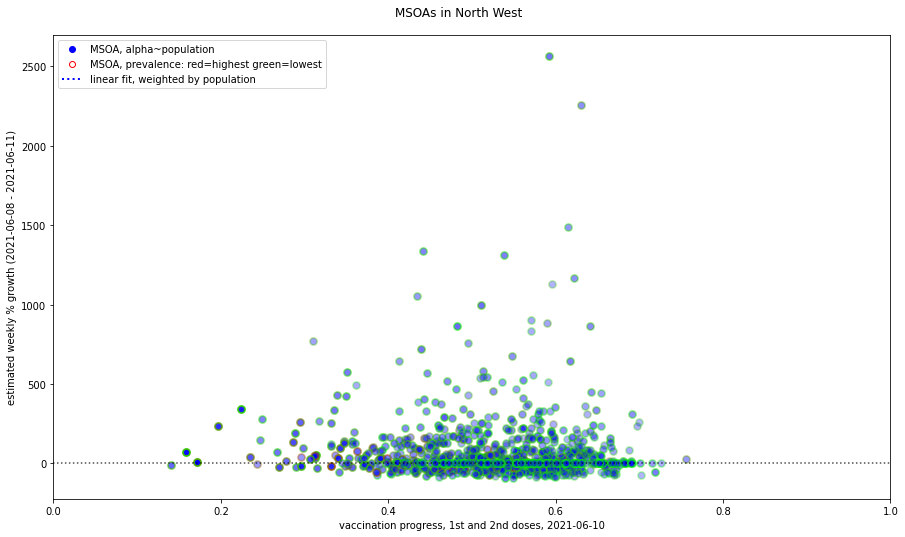

In [22]:
LA_regions = {
  #"North East" : "E12000001",
  "North West" : "E12000002",
  #"Yorkshire and the Humber" : "E12000003",
  #"East Midlands" : "E12000004",
  #"West Midlands" : "E12000005",
  #"East" : "E12000006",
  #"London" : "E12000007",
  #"South East" : "E12000008",
  #"South West" : "E12000009",
}


for region, regionCode in LA_regions.items():
    df_latest = compute_df_latest(df, regionCode)
    draw_graph(region, df_latest)

In [23]:
def draw_graph2(region, df_latest):
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize=(20,12))
    fig.suptitle("MSOAs in %s" % region)
    fig.subplots_adjust(top=0.93)
    
    df_latest.sort_values(by="vaxxed_both_rate", inplace=True)
    
    xs = df_latest.vaxxed_both_rate.to_list()
    xs_ranks = list(range(len(xs)))
    ys = df_latest.newCasesBySpecimenDateRollingSum.to_list()
    names = df_latest.areaName.to_list()
    ltlas = df_latest.LtlaName.to_list()
    gs = np.array(df_latest.growth_rate.to_list())
    es = df_latest.alpha_cases.to_list()
    fs = df_latest.alpha_pop.to_list()
    #print(list(zip(names, xs, ys, gs)))
    
    ltla_colours = {
        #"Bolton" : "orange",
        #"Blackburn with Darwen" : "purple",
    }
    use_ltla_colours = True
    

    y_max = np.max(ys)
    y_max_pred = 0
    for name, ltla, x,y,g,e,f in zip(names, ltlas, xs_ranks,ys,gs,es,fs): # n2s: need to upgrade python to get latest matplotlib which supports alphas as list
        facecolor = "blue"
        if use_ltla_colours and ltla in ltla_colours:
            facecolor = ltla_colours[ltla]
        ax.scatter(x, y, alpha=f, facecolor=facecolor, edgecolor=(e,1-e,0), marker="o", s=60, linewidth=1.75)
        yg = y*g
        y_max_pred = max(y_max_pred, yg)
        if abs(1-yg/y)>.01:
            arrow = ax.annotate("", xy=(x, yg), xytext=(x, y), arrowprops=dict(arrowstyle="->", alpha=0.55))
        #if y>y_max*0.33:
        #    ax.annotate(ltla, xytext=(x+2, y), xy=(x, y), size=8)

    xticks = []
    xticklabels = []
    n_bins = 10
    bins = [0]
    for i in range(1,n_bins):
        j = int(len(xs)*i/n_bins)
        bins.append(j)
        ax.axvline(j, color='grey', linestyle='dotted', alpha=0.4)
        xticks.append(j)
        xticklabels.append("%d%%" % int(xs[j]*100))
    ax.get_xaxis().set_ticks(xticks)
    ax.get_xaxis().set_ticklabels(xticklabels) 
    
    for i in range(len(bins)):
        start = bins[i]
        end = bins[i+1] if i+1<len(bins) else len(ys)
        y_avg = np.mean(ys[start:end])
        ax.hlines(y_avg, color='red', alpha=1, xmin=start, xmax=end)
        yg_avg = np.mean(ys[start:end] * gs[start:end]) 
        x = (start+end)/2
        print(y_avg, yg_avg/y_avg)
        #arrow = ax.annotate("", xy=(x, yg_avg), xytext=(x, y_avg), arrowprops=dict(arrowstyle="->, head_width=0.5", color="red"))
    
    ax.axhline(0, color='black', linestyle='dotted', alpha=0.7)
    ax.set_xlabel("vaccination progress in rank order, %s of 1st and 2nd doses, 2021-06-10")
    ax.set_ylabel("+ve tests week ending %s" % end_date)

    custom_lines = [Line2D([0], [0], marker='o', color=(1,1,1), markeredgecolor=(0,0,1), markerfacecolor=(0,0,1), markersize=6),
                    Line2D([0], [0], marker='o', color=(1,1,1), markeredgecolor=(0,1,0), markerfacecolor=(1,1,1), markersize=6),
                    Line2D([0], [0], color=(1,1,1), lw=2),
                    Line2D([0], [0], color=(1,0,0), lw=2),]
    
    custom_labels = ["MSOA, alpha~population",
                     "MSOA, prevalence: red=highest green=lowest",
                     'arrows: trajectory one day into future, based on %s - %s' % (start_date, end_date),
                     'average y values for deciles',]

    ax.legend(custom_lines, custom_labels, loc = "upper right")
    ax.set_ylim(-1,max(110,y_max_pred+1))
    #ax.set_xlim(0,1)

    filename = region + " " + ax.get_ylabel() + " " + ax.get_xlabel()
    plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
    print(filename)


/home/nic/venv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


29.945652173913043 1.0521751421101515
19.47826086956522 1.0480857283066243
16.43010752688172 1.0335038637105063
14.41304347826087 1.0464402853987624
16.548387096774192 1.0362294640192447
13.25 1.0401177008435933
12.304347826086957 1.033718380855472
11.709677419354838 1.0382386493953486
10.434782608695652 1.0632652792313408
8.236559139784946 1.0535472942047601
North West +ve tests week ending 2021-06-11 vaccination progress in rank order, %s of 1st and 2nd doses, 2021-06-10


<Figure size 432x288 with 0 Axes>

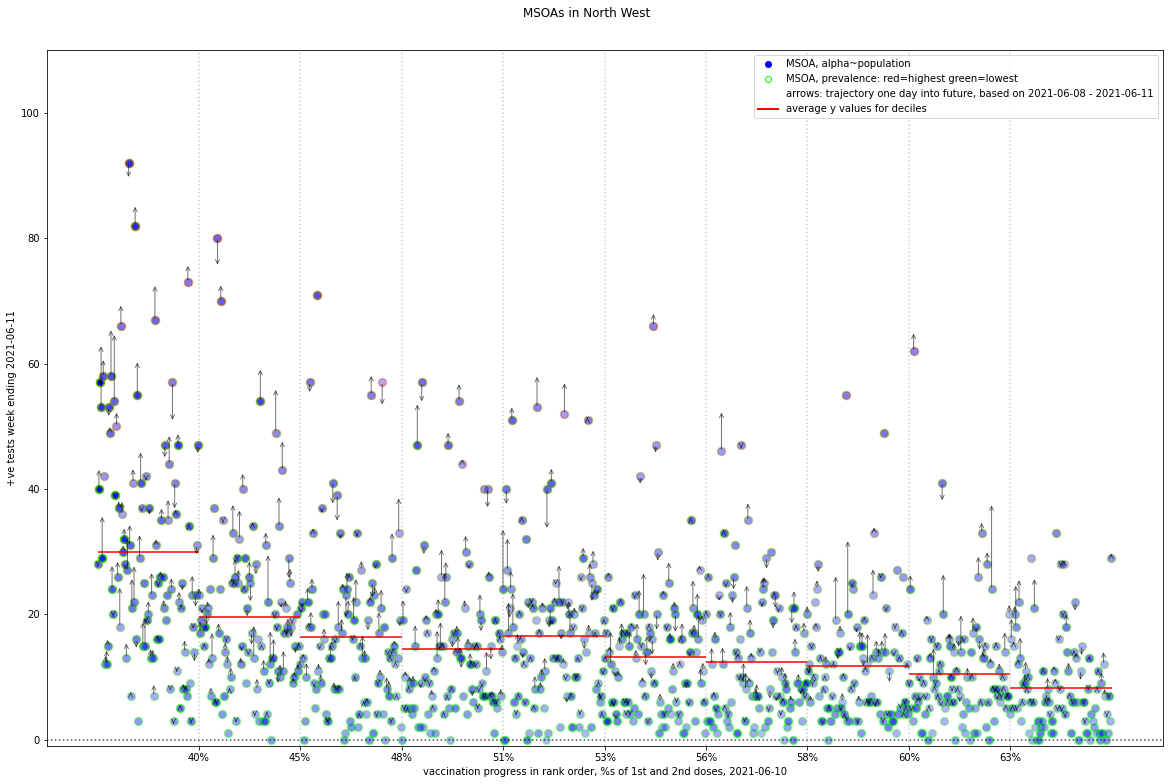

In [24]:
LA_regions = {
  #"North East" : "E12000001",
  "North West" : "E12000002",
  #"Yorkshire and the Humber" : "E12000003",
  #"East Midlands" : "E12000004",
  #"West Midlands" : "E12000005",
  #"East" : "E12000006",
  #"London" : "E12000007",
  #"South East" : "E12000008",
}


for region, regionCode in LA_regions.items():
    df_latest = compute_df_latest(df, regionCode)
    draw_graph2(region, df_latest)